In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.signal import butter, filtfilt

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch

from libs.TrafficGenerator import DatasetConvertor 
from libs.TrafficPredictor.ContextAssisted import PreparingDataset as PreparingDatasetCA
from libs.TrafficPredictor.ContextAssisted import trainModelByDefaultSetting as trainModelCA
from libs.TrafficPredictor.ContextAssisted import evaluateModel as evaluateModelCA
from libs.TrafficPredictor.ContextAssisted import createModel as createModelCA
from libs.TrafficPredictor.HelperFunctions import createDataLoaders

class ButterworthLowPassFilter(nn.Module):
    def __init__(self, fc, fs, order=4):
        super(ButterworthLowPassFilter, self).__init__()
        self.fc = fc
        self.fs = fs
        self.order = order
        self.b, self.a = self.design_filter()

    def design_filter(self):
        nyquist = 0.5 * self.fs
        normalized_cutoff = self.fc / nyquist
        b, a = butter(self.order, normalized_cutoff, btype='low', analog=False)
        return b, a

    def forward(self, x):
        # x should have shape [len, batch_size, dim]
        len_data, batch_size, dim = x.shape
        x_reshaped = x.permute(1, 2, 0).reshape(-1, len_data).cpu().numpy()

        # Apply filter to each sequence (linear operation)
        filtered_data = torch.tensor(
            [filtfilt(self.b, self.a, x_reshaped[i]) for i in range(x_reshaped.shape[0])],
            dtype=x.dtype, device=x.device
        ).reshape(batch_size, dim, len_data).permute(2, 0, 1)

        return filtered_data


In [6]:
dbParams = 0.01
direction = "forward"
#dbParams = 0.05
#direction = "backward"
mode = "fixed"
#mode = "adaptive"
alpha = 0.5

rawDatasetFolder = "Dataset"
datasetConverter = DatasetConvertor(rawDatasetFolder) 
datasetConverter.processDataset(dbParameter=dbParams, alpha=alpha, mode=mode, direction=direction)
thumbUnit = datasetConverter.getDataUnit('thumb_fr')


lenWindow = 30
paramsCA = {}
paramsCA['lenSource'] = lenWindow
paramsCA['lenTarget'] = lenWindow
paramsCA['trainRatio'] = 0.8
paramsCA['dataAugment'] = False
paramsCA['smoothFc'] = 2.5
paramsCA['smoothOrder'] = 3
trainDataCA, testDataCA = PreparingDatasetCA(thumbUnit, paramsCA, verbose=False)

========== thumb ============
Forward: Compression rate:0.22314470485360394
========== index ============
Forward: Compression rate:0.24555334544091786
========== middle ============
Forward: Compression rate:0.24907031047306064


torch.Size([2774, 30, 3])
(30, 2774, 3)


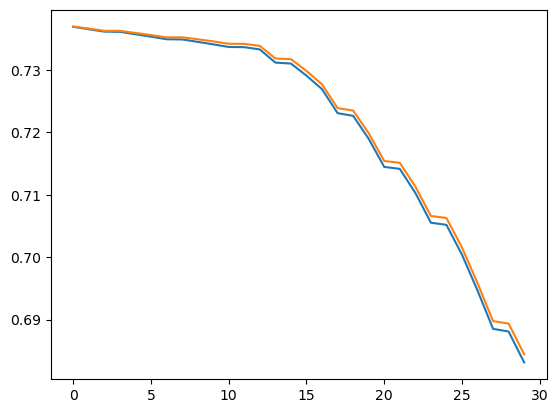

In [7]:
dataloader = createDataLoaders(
    batch_size=4096, dataset=trainDataCA, shuffle=False
)
source = next(iter(dataloader))[0]
print(source.shape)
# Example usage
len_data, batch_size, dim = 1000, 32, 3

fc = 10  # Cutoff frequency
fs = 100.0  # Sampling frequency

model = ButterworthLowPassFilter(fc, fs)
filtered_data = model(source)

source = source.permute(1,0,2).cpu().detach().numpy()
filtered_data = filtered_data.permute(1,0,2).cpu().detach().numpy()
print(filtered_data.shape)

plt.plot(source[:,0,0])
plt.plot(filtered_data[:,0,0])

torch.Size([30, 2774, 3])
(30, 2774, 3)
(30, 2774, 3)


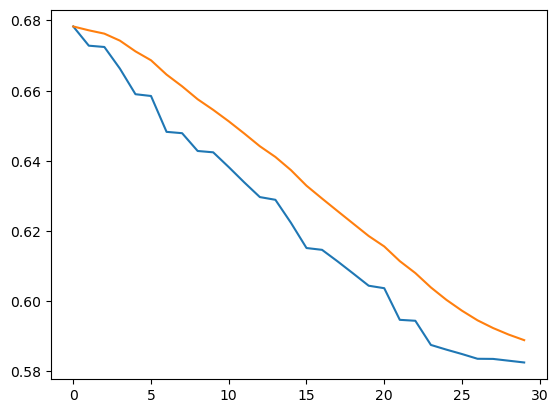

In [12]:
def moving_average_smoothing_optimized(data, window_size=5):
    """
    Applies a moving average smoothing to a 3D tensor of shape [len, batch_size, dim]
    without using a for-loop.
    """
    # Ensure data is 3D: [len, batch_size, dim]
    assert data.ndim == 3, "Input data must be of shape [len, batch_size, dim]"

    # Calculate padding size
    pad_size = window_size // 2
    
    # Manually create reflection padding along the time axis (dim=0)
    data_padded = torch.cat(
        [data[:pad_size].flip(0), data, data[-pad_size:].flip(0)], dim=0
    )
    
    # Reshape for convolution: [batch_size * dim, 1, len]
    data_padded_reshaped = data_padded.permute(1, 2, 0).reshape(-1, 1, data_padded.size(0))
    
    # Applying the moving average using 1D convolution
    kernel = torch.ones(1, 1, window_size, device=data.device) / window_size
    smoothed_reshaped = F.conv1d(data_padded_reshaped, kernel, padding=0)
    
    # Reshape back to original format [len, batch_size, dim]
    smoothed_data = smoothed_reshaped.view(data.size(1), data.size(2), -1).permute(2, 0, 1)
    
    # Truncate to match the original length
    smoothed_data = smoothed_data[:data.size(0)]
    
    return smoothed_data

def exponential_moving_average_smoothing(data, alpha=0.1):
    """
    Applies exponential moving average smoothing to a 3D tensor of shape [len, batch_size, dim].
    """
    smoothed_data = torch.zeros_like(data)
    smoothed_data[0] = data[0]

    for t in range(1, data.size(0)):
        smoothed_data[t] = alpha * data[t] + (1 - alpha) * smoothed_data[t - 1]

    return smoothed_data

dataloader = createDataLoaders(
    batch_size=4096, dataset=trainDataCA, shuffle=False
)
source = next(iter(dataloader))[0].permute(1,0,2)
print(source.shape)
#output = moving_average_smoothing_optimized(source, window_size=5)
output = exponential_moving_average_smoothing(source, alpha=0.2)
source = source.cpu().detach().numpy()
output = output.cpu().detach().numpy()
print(source.shape)
print(output.shape)

plt.plot(source[:,1,0])
plt.plot(output[:,1,0])